## Pipeline

In [2]:
%reload_ext autoreload
%autoreload 2
from termcolor import colored
import dotenv
import sys
import dspy
import os

from tqdm.auto import tqdm

sys.path.append('../pipeline_v2/')
import main 
dotenv.load_dotenv('../.env')

from utils import print_header

import pandas as pd

def print_final_result(statement, verdict, confidence, reasoning, gold_verdict=None):
    # Print final result
    print("\nFinal Fact-Check Result:")
    print_header(f"Statement: {colored(statement, 'white')}", level=1)
    print_header(f"Overall Verdict: {colored(verdict, 'green')}", level=1)
    print_header(f"Overall Confidence: {colored(str(confidence), 'yellow')}", level=1)
    print_header(f"Overall Reasoning: {colored(reasoning, 'cyan')}", level=1)
    if gold_verdict: print_header(f"Gold Verdict: {colored(gold_verdict, 'green')}", level=1)

In [ ]:
### Load data
if os.path.exists('results_v2.pkl'):
    df = pd.read_pickle('results_v2.pkl')
else: 
    df = pd.read_csv('../data/pilot_updated_v2.csv')

    # # Drop unneeded columns
    df.drop(columns=['Assignee', 'questions to verify the statement', 'Gold Label', 'factcheck_date'], inplace=True)

    # Reformat dates
    df['statement_date'] = pd.to_datetime(df['statement_date']).dt.strftime("%B %d, %Y")

df

In [17]:
# Set custom constants for whole pipeline
main.VERBOSE = True # Print intermediate results
# main.VERDICTS=["Supported", "Refuted", "Not Enough Evidence", "Conflicting Evidence/Cherry-picking"]

# Initialize DSPy
# lm = dspy.LM('gemini/gemini-1.5-flash', api_key=os.getenv('GOOGLE_GEMINI_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/mistral', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/mistralai/mistral-7b-instruct:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/llama3.1:8b', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/meta-llama/llama-3.1-8b-instruct:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/deepseek-r1:7b', api_base='http://localhost:11434', api_key='', cache=False)
lm = dspy.LM('openrouter/deepseek/deepseek-r1-distill-llama-70b:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('openrouter/deepseek/deepseek-r1:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
dspy.settings.configure(lm=lm, temperature=0.3)

pipeline = main.FactCheckPipeline(
    search_provider=main.SearchProvider(provider="duckduckgo"),
    model_name=lm,
    embedding_model=main.EMBEDDING_MODEL,
    retriever_k=5
)

In [18]:
# Test with a single statement from dataset
index = -1
statement = df.iloc[index]['statement']
statement_originator = df.iloc[index]['statement_originator']
statement_date = df.iloc[index]['statement_date']
gold_verdict = df.iloc[index]['verdict']

verdict, confidence, reasoning, claims = pipeline.fact_check(
    # statement=f"According to {statement_originator} on {statement_date}, {statement}", 
    statement=f"On {statement_date}, {statement_originator} claimed: {statement}", 
    # statement=statement, 
    # context=f"Statement Originator: {statement_originator}, Date Claim Was Made: {statement_date}"
)
print_final_result(statement, verdict, confidence, reasoning, gold_verdict)

===== Starting Fact Check Pipeline =====
 Original Statement: On January 10, 2024, Deputy White House press secretary Andrew Bates claimed: "House Republicans took numerous votes that would have damaged economic growth and harmed our national security, like attempting to eliminate over 2,000 Border Patrol agents." 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. House Republicans took numerous votes that would have damaged economic growth and harmed our national security, like attempting to eliminate over 2,000 Border Patrol agents. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: What votes have House Republicans taken that could potentially harm economic growth? 
            Search Queries: ['House Republicans votes economic growth impact', 'House GOP economic growth harmful votes'] 
         2. Question: Did House Republicans vote to eliminate over 2,000 Border Patrol agents, and

        ===== Web Search for Query [2/2] =====
         Query: House GOP economic growth harmful votes 
         Retrieved 10 Sources: 
           1. Club for Growth names the best, and worst, Republicans on the economy 
           URL: https://perry.house.gov/news/documentsingle.aspx?DocumentID=402876 
           Excerpt: The scorecard does not include all legislation but rather what the Club for Growth considers "key bills that either promote or undermine the principles of economic freedom and limited government." Of the more than 1,000 combined floor votes between the House and Senate, the organization included 17 House votes and 14 Senate votes. 
           2. Conservative ire threatens to jeopardize key vote on Donald Trump ... 
           URL: https://thehill.com/homenews/house/5122385-conservative-ire-threatens-to-jeopardize-key-vote-on-trump-agenda-bill/ 
           Excerpt: Speaker Mike Johnson's (R-La.) plan to hold a key vote for the GOP's sweeping agenda bill this week is i

      ===== Synthesizing Answer [1/2] =====
         Question: What votes have House Republicans taken that could potentially harm economic growth? 
         Search Queries: ['House Republicans votes economic growth impact', 'House GOP economic growth harmful votes'] 


         Answer: {
    "text": "House Republicans have taken several votes that could potentially harm economic growth. They voted to permanently extend individual tax cuts [2], which may increase the deficit and lead to higher inflation. Additionally, they passed the Limit, Save, Grow Act aimed at reducing spending, which might cut investments in growth-stimulating areas [3]. They also passed the REIN IN Act, requiring inflation impact assessments, potentially delaying pro-growth regulations [5]. These actions, while intended to boost the economy, carry risks that could negatively impact economic growth."
    "citations": [
        {
            "snippet": "The House on Friday voted to permanently extend the individual rate cuts in the GOP's $1.5 trillion tax-cut law as part of Republicans' 'Tax reform 2.0' effort...",
            "source_url": "https://apnews.com/article/business-laws-bills-tax-reform-kevin-brady-dc7e3eb56a0a185f9c38c67e90a24076",
            "source_title": "House v

        ===== Web Search for Query [2/2] =====
         Query: Impact of reducing Border Patrol agents on national security 
         Retrieved 10 Sources: 
           1. Border Crisis: CBP's Response - U.S. Customs and Border Protection 
           URL: https://www.cbp.gov/frontline/border-crisis-cbp-s-response 
           Excerpt: "Border security is national security — there is no difference — and the crisis on our southwest border puts our national security at risk," U.S. Border Patrol Chief Carla Provost told a House subcommittee dealing with Homeland Security, June 20. ... significantly reducing agents' presence on the border. "On a daily basis, agents ... 
           2. CBP Releases December 2024 Monthly Update | U.S. Customs and Border ... 
           URL: https://www.cbp.gov/newsroom/national-media-release/cbp-releases-december-2024-monthly-update 
           Excerpt: WASHINGTON - U.S. Customs and Border Protection (CBP) released operational statistics today for December 2024.

      ===== Synthesizing Answer [2/2] =====
         Question: Did House Republicans vote to eliminate over 2,000 Border Patrol agents, and how would this impact national security? 
         Search Queries: ['House Republicans Border Patrol agents elimination vote', 'Impact of reducing Border Patrol agents on national security'] 


         Answer: House Republicans did not vote to eliminate over 2,000 Border Patrol agents, but they did oppose funding for hiring additional agents [1]. This could impact national security by potentially reducing border control effectiveness and increasing risks like drug smuggling [2]. 

Reasoning: The claim that House Republicans voted to eliminate over 2,000 Border Patrol agents originated from the White House, but fact-checks indicate this is misleading. Republicans actually voted against funding increases for hiring more agents, which could affect future border security. Reducing the number of Border Patrol agents could lead to increased national security risks, such as heightened illegal activities and drug trafficking. 
         Citations:  
           [1] FACT: Despite tough talk on border security, Republicans voted against necessary funding, opposing $7.2 billion for Border Patrol operations, including for hiring; $65 million for 300 more Border Patrol agents; and $60 mill

In [ ]:
lm.inspect_history(n=10)

In [ ]:
model = 'gemini-1.5-pro'
num_trials = 3

# If column doesn't exist, create it
if f'{model}_results' not in df.columns: df[f'{model}_results'] = None
df[f'{model}_results'] = df[f'{model}_results'].astype(object)

for index in tqdm(range(len(df))):
    # If results already exist, skip if num_trials is reached
    if df.loc[index, f'{model}_results'] is not None: 
        if len(df.loc[index, f'{model}_results']) == num_trials:
            continue
        else:
            results = df.loc[index, f'{model}_results']
    else: 
        results = []

    for trial_i in tqdm(range(num_trials), leave=False):
        statement = df.iloc[index]['statement']
        statement_originator = df.iloc[index]['statement_originator']
        statement_date = df.iloc[index]['statement_date']
        gold_verdict = df.iloc[index]['verdict']

        verdict, confidence, reasoning, claims = pipeline.fact_check(
            statement=statement, 
            context=f"Statement Originator: {statement_originator}, Date Claim Was Made: {statement_date}"
        )
        results.append({
            'verdict': verdict,
            'confidence': confidence,
            'reasoning': reasoning,
            'claims': claims
        })

        print_final_result(statement, verdict, confidence, reasoning, gold_verdict)

    # Update the dataframe
    df.at[index, f'{model}_results'] = results

In [11]:
df.to_pickle('results_v2.pkl')

## Search Testing

In [76]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0",
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
}
results = DDGS(headers=headers).text(query.lower(), max_results=num_results)
results

[{'title': 'Alphabet Inc. (GOOG) Stock Price, News, Quote & History - Yahoo Finance',
  'href': 'https://finance.yahoo.com/quote/GOOG/',
  'body': 'Find the latest Alphabet Inc. (GOOG) stock quote, history, news and other vital information to help you with your stock trading and investing.'},
 {'title': 'Alphabet Inc Class A (GOOGL) Stock Price & News - Google Finance',
  'href': 'https://www.google.com/finance/quote/GOOGL:NASDAQ',
  'body': 'Get the latest Alphabet Inc Class A (GOOGL) real-time quote, historical performance, charts, and other financial information to help you make more informed trading and investment decisions.'},
 {'title': 'GOOGL Stock Price | Alphabet Inc. Cl A Stock Quote (U.S.: Nasdaq ...',
  'href': 'https://www.marketwatch.com/investing/stock/googl',
  'body': 'GOOGL | Complete Alphabet Inc. Cl A stock news by MarketWatch. View real-time stock prices and stock quotes for a full financial overview.'},
 {'title': 'Alphabet Inc. Cl A (GOOGL) Stock Price Today - WS

In [74]:
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

pd.read_html('https://free-proxy-list.net/', headers=hdr)

TypeError: read_html() got an unexpected keyword argument 'headers'

In [77]:
from duckduckgo_search import DDGS
from itertools import cycle

proxy_pool = """
143.107.199.248:8080
""".strip().split('\n')
# 98.80.66.1:10018

proxy_cycle = cycle(proxy_pool)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

def get_results_with_rotation(query, num_results):
    while True:
        current_proxy = next(proxy_cycle)
        try:
            with DDGS(proxy={'http': current_proxy, 'https': current_proxy}, headers=headers) as ddgs:
                results = ddgs.text(query.lower(), max_results=num_results)
            print(f"Success with proxy {current_proxy}")
            return results
        except Exception as e:
            print(f"Error with proxy {current_proxy}: {e}")
            continue

get_results_with_rotation('google stock price', 10)

/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/duckduckgo_search/duckduckgo_search.py:69: UserWarning: 'proxies' is deprecated, use 'proxy' instead.
  warnings.warn("'proxies' is deprecated, use 'proxy' instead.", stacklevel=1)


Error with proxy 143.107.199.248:8080: https://html.duckduckgo.com/html 202 Ratelimit


KeyboardInterrupt: 

## Baseline

In [40]:
 class StatementFactCheckerSignature(dspy.Signature):
    f"""Fact check the given statement into one of the following verdicts: {", ".join(main.VERDICTS)}"""
    statement = dspy.InputField(desc="Statement to evaluate")
    verdict = dspy.OutputField(desc=f"Truthful classification of the statement into one of the following verdicts: {', '.join(main.VERDICTS)}")

class StatementFactChecker(dspy.Module):
    def __init__(self):
        super().__init__()
        self.fact_check = dspy.ChainOfThought(StatementFactCheckerSignature)

    def forward(self, statement: str):
        result = self.fact_check(statement=statement)
        verdict = result["verdict"]
        reasoning = result["reasoning"]
        return verdict, reasoning
    

In [ ]:
# Test with a single statement from dataset
index = 4
statement = df.iloc[index]['statement']
statement_originator = df.iloc[index]['statement_originator']
statement_date = df.iloc[index]['statement_date']
gold_verdict = df.iloc[index]['verdict']

fact_checker = StatementFactChecker()
verdict, reasoning = fact_checker(f"On {statement_date}, {statement_originator} claimed: {statement}")
print_final_result(statement, verdict, 1, reasoning, gold_verdict)


Final Fact-Check Result:
   Statement: “The Universities of Wisconsin are 43rd out of 50 states in the nation, in terms of public support for our universities. The $855 million (budget request) gets us up to average.” 
   Overall Verdict: MOSTLY FALSE 
   Overall Confidence: 1 
   Overall Reasoning: Jay Rothman's claim that the Universities of Wisconsin rank 43rd out of 50 states in terms of public support needs verification. Recent data suggests that Wisconsin's public universities are not typically ranked that low. Additionally, the assertion that a $855 million budget request would bring funding up to average requires context about current funding levels and how this amount compares to other states. 
   Gold Verdict: TRUE 


## Analysis

In [3]:
import pandas as pd

model = "gemini"

df = pd.read_pickle(f'results_v2_{model}.pkl')

df['verdict'] = df['verdict'].replace({'PANTS ON FIRE': 'FALSE'})

VERDICTS = ["TRUE", "MOSTLY TRUE", "HALF TRUE", 
            "MOSTLY FALSE", "FALSE", "UNVERIFIABLE"]

# Extract the verdicts from the gemini_results column
df['pred_verdicts_baseline'] = df[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
df['pred_verdicts_pipeline'] = df[f'{model}_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

# Make new column that checks if the true verdict is in the top 3 of the model's verdicts
# df['pred_verdicts_baseline_top3'] = df.apply(lambda row: row['verdict'] in row['pred_verdicts_baseline'][:3], axis=1)
# df['pred_verdicts_pipeline_top3'] = df.apply(lambda row: row['verdict'] in row['pred_verdicts_pipeline'][:3], axis=1)

# Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
# "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
# 'UNVERIFIABLE (as of now)': 0,
# 'MOSTLY FALSE (for the first claim) and FALSE (for the second claim)': 2,
# 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
for i, row in df.iterrows():
    cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
    for col in cols: 
        verdicts = row[col]
        verdicts = [v.split(':')[0].split('-')[0].split('(')[0].strip() if len(v) > 12 else v for v in verdicts]
        df.at[i, col] = verdicts

df[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

,verdict,pred_verdicts_baseline,pred_verdicts_pipeline
0,MOSTLY TRUE,"[MOSTLY TRUE, UNVERIFIABLE, MOSTLY TRUE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
1,TRUE,"[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
2,FALSE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[UNVERIFIABLE, UNVERIFIABLE, FALSE]"
3,HALF TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[UNVERIFIABLE, MOSTLY FALSE, UNVERIFIABLE]"
4,TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
...,...,...,...
145,FALSE,"[TRUE, TRUE, TRUE]","[FALSE, FALSE, UNVERIFIABLE]"
146,HALF TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY FALSE]","[MOSTLY FALSE, UNVERIFIABLE, MOSTLY FALSE]"
147,MOSTLY TRUE,"[MOSTLY TRUE, MOSTLY FALSE, MOSTLY FALSE]","[UNVERIFIABLE, UNVERIFIABLE, MOSTLY FALSE]"
148,FALSE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]"


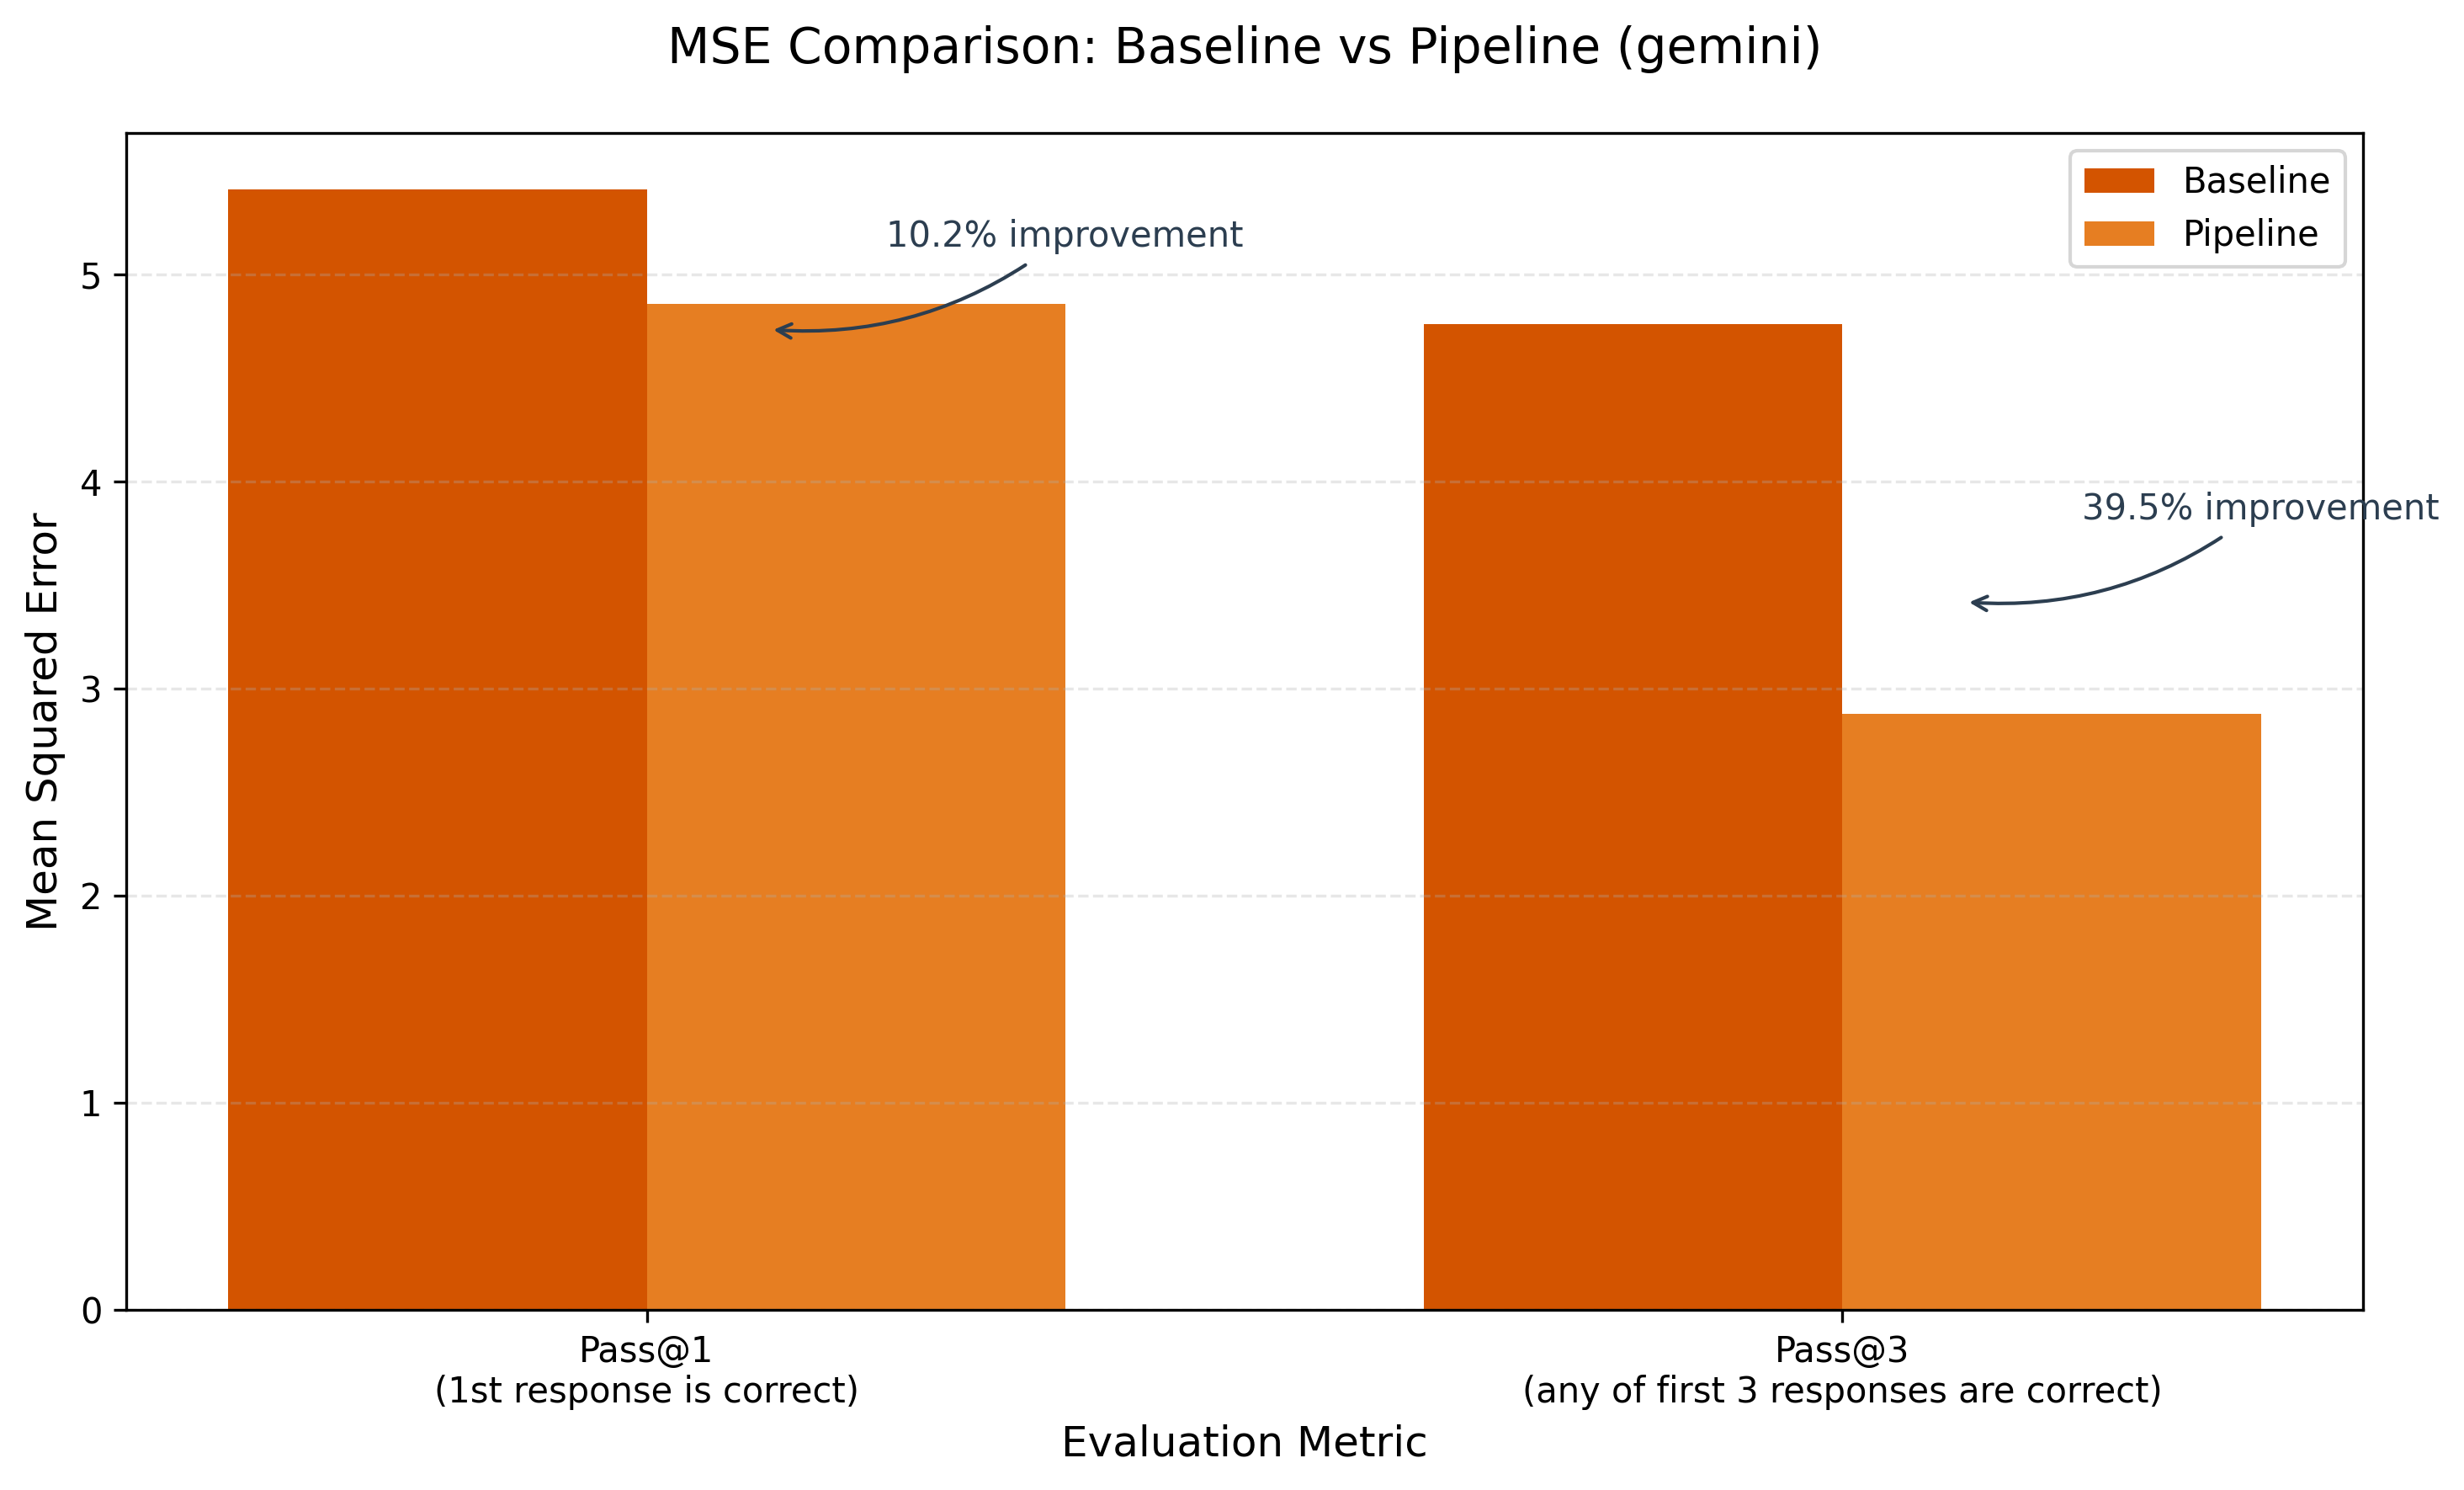

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate ordinal metrics (just MSE for now)
ordinal_metrics = {}

# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "MOSTLY UNVERIFIABLE": 0,}

# Convert verdicts to numeric values
true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]

for benchmark in ['baseline', 'pipeline']:
    col = f'pred_verdicts_{benchmark}'

    # pass@1: calculate MSE using ONLY the first trial prediction
    first_preds = [VERDICT_MAP[pred_list[0]] for pred_list in df[col]]
    ordinal_metrics[f'{benchmark}_pass@1_mse'] = np.mean((np.array(true_verdicts) - np.array(first_preds)) ** 2)
    
    # pass@3: calculate MSE using best prediction across all 3 trials
    best_preds = [] 
    for i, pred_list in enumerate(df[col]): # for each 
        true_verdict = true_verdicts[i] # Get true verdict

        # Convert predictions to numeric values
        pred_nums = [VERDICT_MAP[pred] for pred in pred_list]
        
        # Find prediction with smallest error
        errors = [(pred - true_verdict)**2 for pred in pred_nums]
        best_pred = pred_nums[np.argmin(errors)]
        best_preds.append(best_pred)
        
    ordinal_metrics[f'{benchmark}_pass@3_mse'] = np.mean((np.array(true_verdicts) - np.array(best_preds)) ** 2)

# Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
plt.figure(figsize=(10, 6), dpi=300)

# Define fall colors
colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
bar_width = 0.35
index = np.arange(2)  # Two groups for Pass@1 and Pass@3

# Create bars
baseline_bars = plt.bar(index - bar_width/2, 
                       [ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['baseline_pass@3_mse']], 
                       bar_width, label='Baseline', color=colors[0])
pipeline_bars = plt.bar(index + bar_width/2, 
                       [ordinal_metrics['pipeline_pass@1_mse'], ordinal_metrics['pipeline_pass@3_mse']], 
                       bar_width, label='Pipeline', color=colors[1])

# Customize the plot
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title(f'MSE Comparison: Baseline vs Pipeline ({model})', fontsize=14, pad=20)
plt.xticks(index, ["Pass@1\n(1st response is correct)", "Pass@3\n(any of first 3 responses are correct)"])
plt.legend()

# Add improvement arrows and percentages
for idx, (baseline, pipeline) in enumerate([
    (ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['pipeline_pass@1_mse']),
    (ordinal_metrics['baseline_pass@3_mse'], ordinal_metrics['pipeline_pass@3_mse'])
]):
    improvement = ((baseline - pipeline) / baseline * 100)
    
    # Draw arrow
    mid_height = (baseline + pipeline) / 2
    plt.annotate(
        f'{improvement:.1f}% improvement', 
        xy=(idx + 0.1, mid_height - 0.4),
        xytext=(idx + 0.2, mid_height),
        fontsize=10,
        color='#2C3E50',  # Dark blue-gray
        arrowprops=dict(
            arrowstyle='->',
            color='#2C3E50',
            connectionstyle='arc3,rad=-0.2'
        )
    )

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()

In [18]:
import pandas as pd

model = "mistral"

df = pd.read_pickle(f'results_v2_{model}.pkl')

df['verdict'] = df['verdict'].replace({'PANTS ON FIRE': 'FALSE'})

VERDICTS = ["TRUE", "MOSTLY TRUE", "HALF TRUE", 
            "MOSTLY FALSE", "FALSE", "UNVERIFIABLE"]

# Extract the verdicts from the gemini_results column
df['pred_verdicts_baseline'] = df[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
df['pred_verdicts_pipeline'] = df[f'{model}_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

# Make new column that checks if the true verdict is in the top 3 of the model's verdicts
# df['pred_verdicts_baseline_top3'] = df.apply(lambda row: row['verdict'] in row['pred_verdicts_baseline'][:3], axis=1)
# df['pred_verdicts_pipeline_top3'] = df.apply(lambda row: row['verdict'] in row['pred_verdicts_pipeline'][:3], axis=1)

# Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
# "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
# 'UNVERIFIABLE (as of now)': 0,
# 'MOSTLY FALSE (for the first claim) and FALSE (for the second claim)': 2,
# 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
for i, row in df.iterrows():
    cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
    for col in cols: 
        verdicts = row[col]
        verdicts = [v.split(':')[0].split('-')[0].split('(')[0].strip() if len(v) > 12 else v for v in verdicts]
        df.at[i, col] = verdicts

df[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

,verdict,pred_verdicts_baseline,pred_verdicts_pipeline
0,MOSTLY TRUE,"[MOSTLY TRUE, MOSTLY TRUE, MOSTLY FALSE]","[MOSTLY TRUE, HALF TRUE, MOSTLY TRUE]"
1,TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY TRUE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY FALSE]"
2,FALSE,"[UNVERIFIABLE, UNVERIFIABLE, MOSTLY UNVERIFIABLE]","[MOSTLY FALSE, MOSTLY FALSE, HALF TRUE]"
3,HALF TRUE,"[MOSTLY UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY FALSE, HALF TRUE, UNVERIFIABLE]"
4,TRUE,"[UNVERIFIABLE, MOSTLY UNVERIFIABLE, UNVERIFIABLE]","[UNVERIFIABLE, UNVERIFIABLE, MOSTLY TRUE]"
...,...,...,...
145,FALSE,"[MOSTLY FALSE, MOSTLY TRUE, TRUE]","[MOSTLY FALSE, UNVERIFIABLE, MOSTLY FALSE]"
146,HALF TRUE,"[MOSTLY FALSE, MOSTLY FALSE, FALSE]","[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]"
147,MOSTLY TRUE,"[UNVERIFIABLE, MOSTLY FALSE, MOSTLY FALSE]","[MOSTLY FALSE, MOSTLY FALSE, UNVERIFIABLE]"
148,FALSE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY FALSE, MOSTLY FALSE, UNVERIFIABLE]"


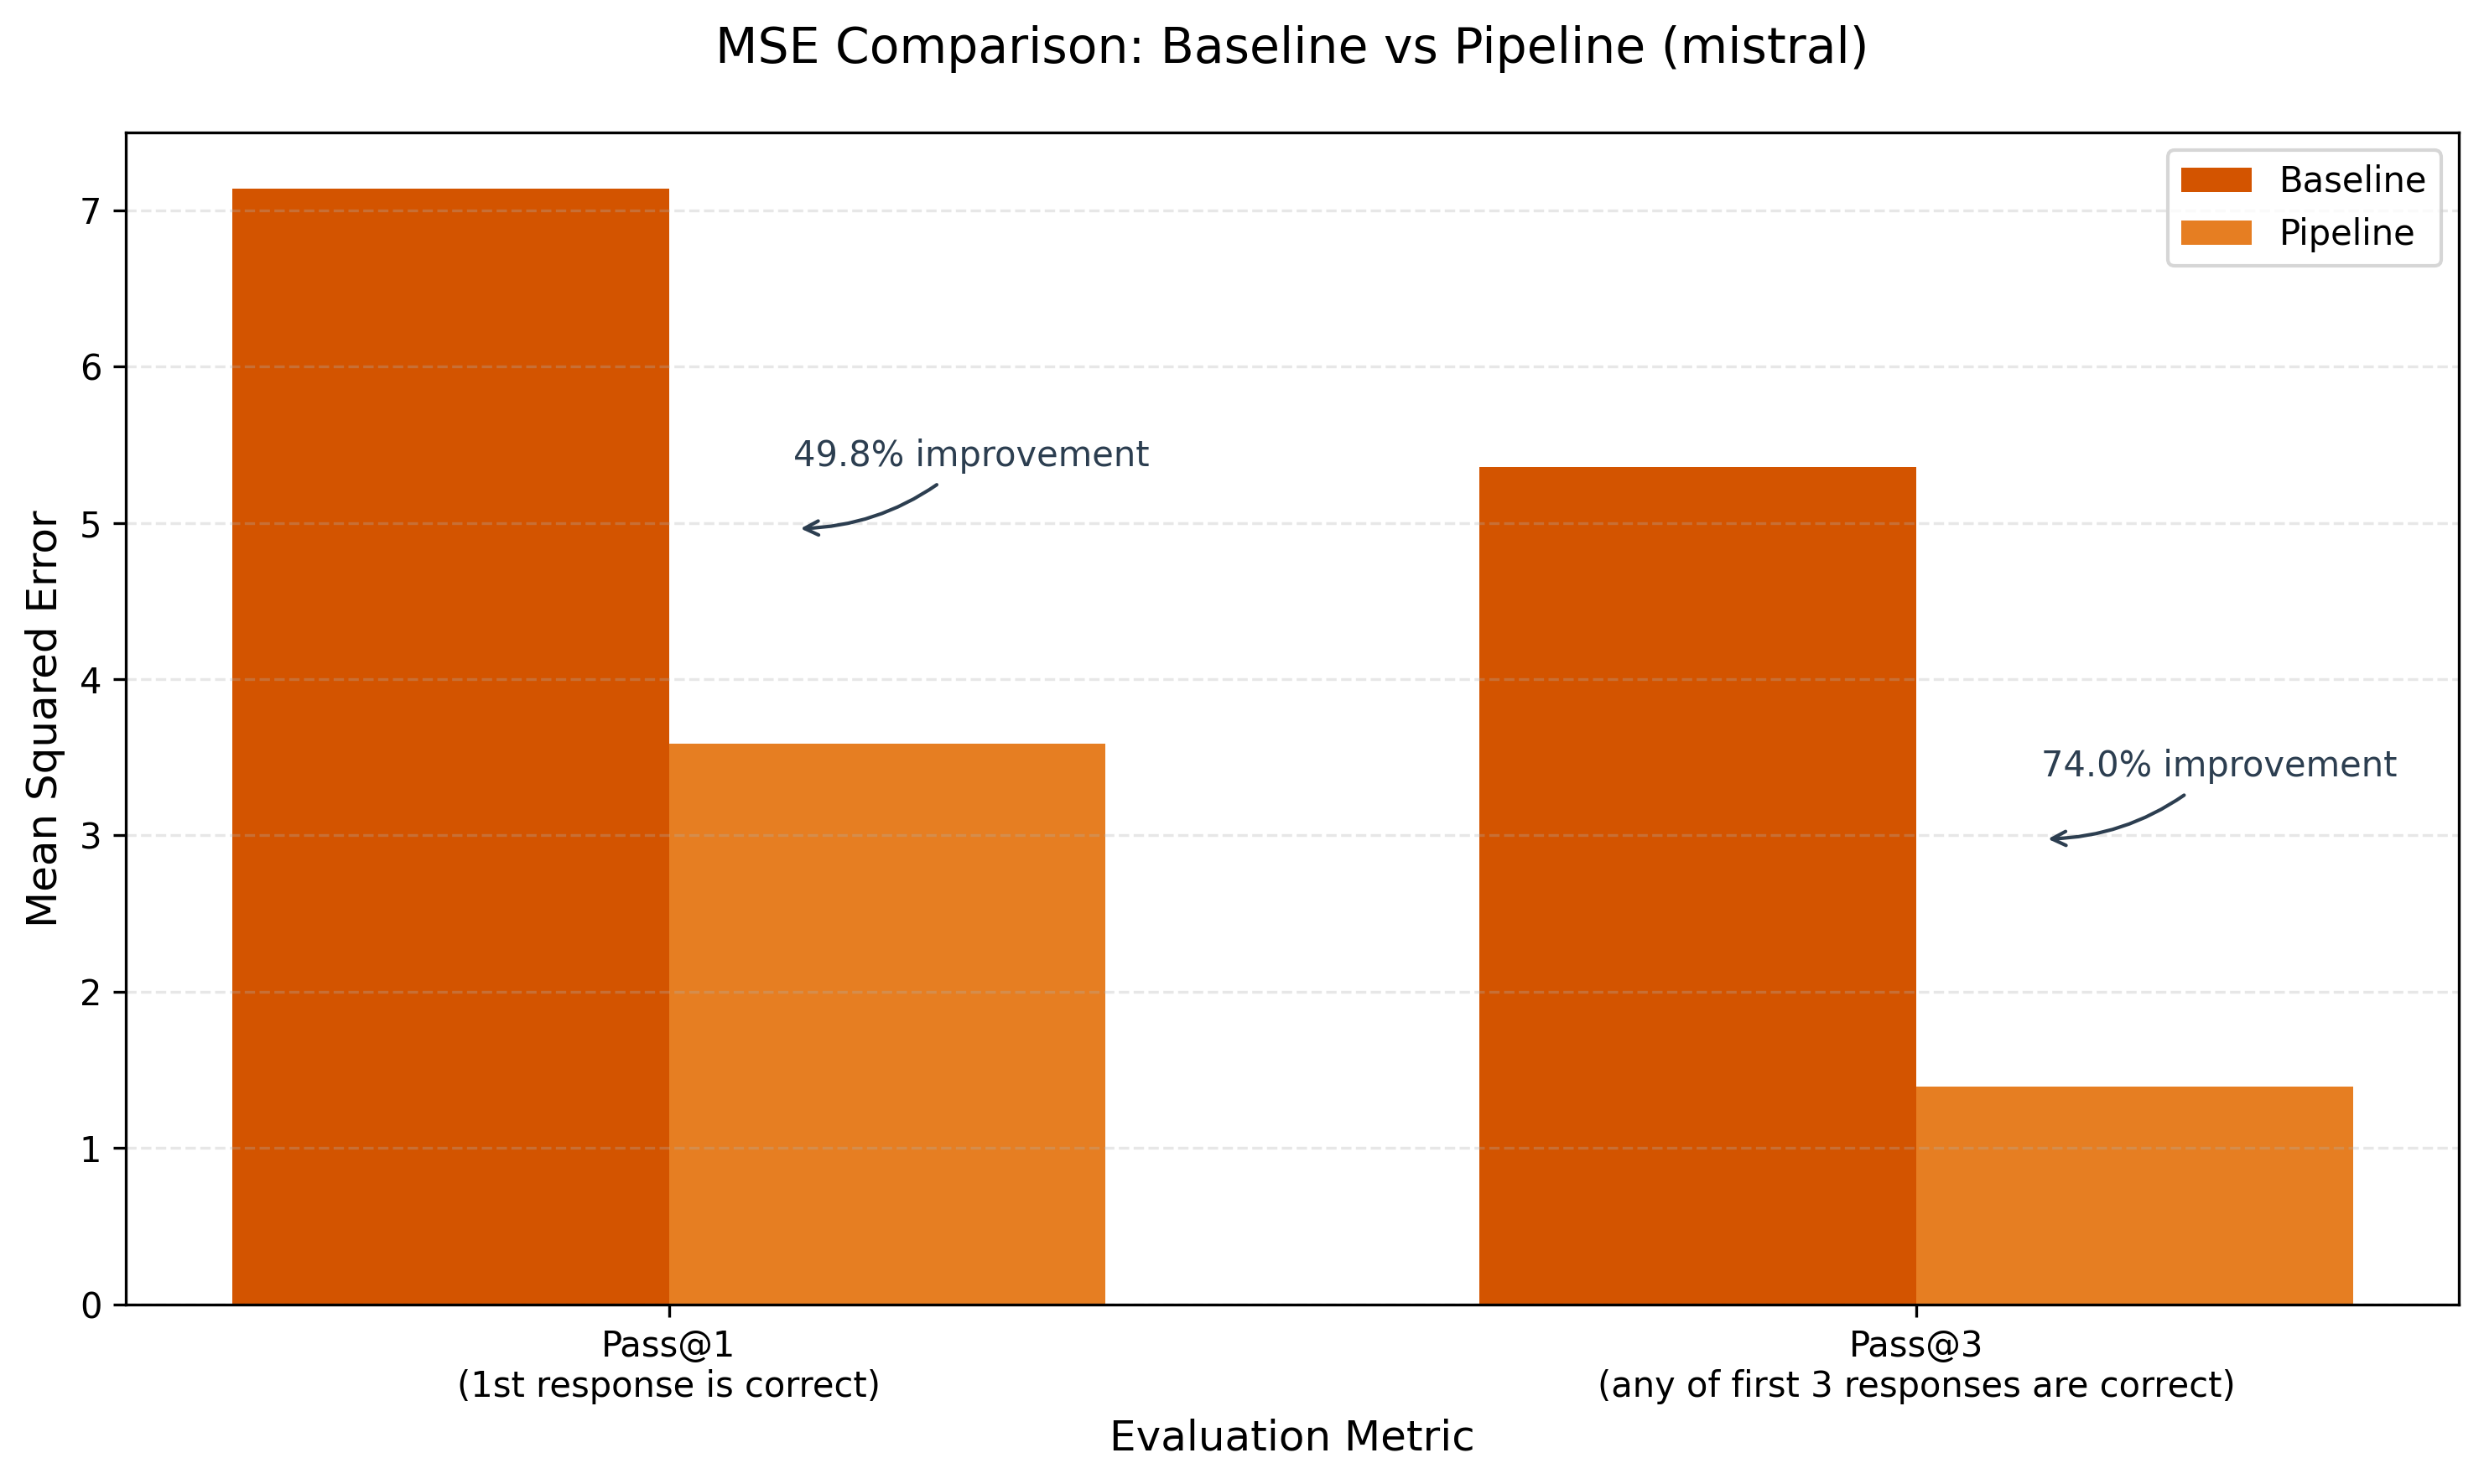

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate ordinal metrics (just MSE for now)
ordinal_metrics = {}

# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "MOSTLY UNVERIFIABLE": 0,}

# Convert verdicts to numeric values
true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]

for benchmark in ['baseline', 'pipeline']:
    col = f'pred_verdicts_{benchmark}'

    # pass@1: calculate MSE using ONLY the first trial prediction
    first_preds = [VERDICT_MAP[pred_list[0]] for pred_list in df[col]]
    ordinal_metrics[f'{benchmark}_pass@1_mse'] = np.mean((np.array(true_verdicts) - np.array(first_preds)) ** 2)
    
    # pass@3: calculate MSE using best prediction across all 3 trials
    best_preds = [] 
    for i, pred_list in enumerate(df[col]): # for each 
        true_verdict = true_verdicts[i] # Get true verdict

        # Convert predictions to numeric values
        pred_nums = [VERDICT_MAP[pred] for pred in pred_list]
        
        # Find prediction with smallest error
        errors = [(pred - true_verdict)**2 for pred in pred_nums]
        best_pred = pred_nums[np.argmin(errors)]
        best_preds.append(best_pred)
        
    ordinal_metrics[f'{benchmark}_pass@3_mse'] = np.mean((np.array(true_verdicts) - np.array(best_preds)) ** 2)

# Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
plt.figure(figsize=(10, 6), dpi=300)

# Define fall colors
colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
bar_width = 0.35
index = np.arange(2)  # Two groups for Pass@1 and Pass@3

# Create bars
baseline_bars = plt.bar(index - bar_width/2, 
                       [ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['baseline_pass@3_mse']], 
                       bar_width, label='Baseline', color=colors[0])
pipeline_bars = plt.bar(index + bar_width/2, 
                       [ordinal_metrics['pipeline_pass@1_mse'], ordinal_metrics['pipeline_pass@3_mse']], 
                       bar_width, label='Pipeline', color=colors[1])

# Customize the plot
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title(f'MSE Comparison: Baseline vs Pipeline ({model})', fontsize=14, pad=20)
plt.xticks(index, ["Pass@1\n(1st response is correct)", "Pass@3\n(any of first 3 responses are correct)"])
plt.legend()

# Add improvement arrows and percentages
for idx, (baseline, pipeline) in enumerate([
    (ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['pipeline_pass@1_mse']),
    (ordinal_metrics['baseline_pass@3_mse'], ordinal_metrics['pipeline_pass@3_mse'])
]):
    improvement = ((baseline - pipeline) / baseline * 100)
    
    # Draw arrow
    mid_height = (baseline + pipeline) / 2
    plt.annotate(
        f'{improvement:.1f}% improvement', 
        xy=(idx + 0.1, mid_height - 0.4),
        xytext=(idx + 0.1, mid_height),
        fontsize=10,
        color='#2C3E50',  # Dark blue-gray
        arrowprops=dict(
            arrowstyle='->',
            color='#2C3E50',
            connectionstyle='arc3,rad=-0.2'
        )
    )

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()

In [176]:
# from sklearn.metrics import confusion_matrix

# def get_first_predictions(prediction_list):
#     """Extract first prediction from each trial list"""
#     return [pred_list[0] for pred_list in prediction_list]

# def create_confusion_matrices(df):
#     """Generate and plot confusion matrices for both models"""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
#     for idx, model in enumerate(['baseline', 'pipeline']):
#         first_preds = get_first_predictions(df[f'pred_verdicts_{model}'])
#         cm = confusion_matrix(df['verdict'], first_preds, labels=VERDICTS)
        
#         # Normalize confusion matrix
#         cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
#         sns.heatmap(cm_norm, annot=True, fmt='.2f', 
#                    xticklabels=VERDICTS, yticklabels=VERDICTS,
#                    ax=[ax1, ax2][idx], cmap='YlOrRd')
#         [ax1, ax2][idx].set_title(f'{model.capitalize()} Model Confusion Matrix')
#         [ax1, ax2][idx].set_xticklabels(VERDICTS, rotation=45)
        
#     plt.tight_layout()
#     return fig

# def analyze_consistency(df):
#     """Analyze model consistency across trials"""
#     consistency_metrics = {}
    
#     for model in ['baseline', 'pipeline']:
#         pred_col = f'pred_verdicts_{model}'
        
#         # Calculate percentage of consistent predictions across trials
#         consistency = df[pred_col].apply(lambda x: len(set(x)) == 1)
#         consistency_metrics[f'{model}_consistency'] = consistency.mean()
        
#         # Analyze most common disagreements
#         disagreements = df[~consistency][['verdict', pred_col]].copy()
#         disagreements['prediction_set'] = disagreements[pred_col].apply(lambda x: tuple(sorted(set(x))))
        
#         # Count most common disagreement patterns
#         consistency_metrics[f'{model}_common_disagreements'] = disagreements['prediction_set'].value_counts().head()
    
#     return consistency_metrics

# def analyze_performance_by_category(df):
#     """Analyze performance on different verdict categories"""
#     fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
#     # Clear cases (TRUE/FALSE) vs nuanced cases
#     clear_cases = df[df['verdict'].isin(['TRUE', 'FALSE'])]
#     nuanced_cases = df[df['verdict'].isin(['MOSTLY TRUE', 'MOSTLY FALSE', 'HALF TRUE'])]
    
#     for idx, (cases, title) in enumerate([(clear_cases, 'Clear Cases'), 
#                                         (nuanced_cases, 'Nuanced Cases')]):
#         accuracy_data = []
#         for model in ['baseline', 'pipeline']:
#             first_preds = get_first_predictions(cases[f'pred_verdicts_{model}'])
#             accuracy = (cases['verdict'] == first_preds).mean()
#             accuracy_data.append({'Model': model.capitalize(), 'Accuracy': accuracy})
        
#         accuracy_df = pd.DataFrame(accuracy_data)
#         sns.barplot(data=accuracy_df, x='Model', y='Accuracy', ax=axes[idx])
#         axes[idx].set_title(f'Accuracy on {title}')
#         axes[idx].set_ylim(0, 1)
    
#     plt.tight_layout()
#     return fig

# def generate_summary_report(df):
#     """Generate comprehensive analysis report"""
#     # Calculate all metrics
#     # ordinal_metrics = calculate_ordinal_metrics(df)
#     consistency_metrics = analyze_consistency(df)
    
#     # Generate figures
#     confusion_fig = create_confusion_matrices(df)
#     performance_fig = analyze_performance_by_category(df)
    
#     # Print summary
#     print("\nAnalysis Summary:")
#     print("\nOrdinal Metrics:")
#     for metric, value in ordinal_metrics.items():
#         print(f"{metric}: {value:.4f}")
    
#     print("\nConsistency Metrics:")
#     for metric, value in consistency_metrics.items():
#         if isinstance(value, float):
#             print(f"{metric}: {value:.4f}")
#         else:
#             print(f"\n{metric}:")
#             print(value)
    
#     # Save figures
#     confusion_fig.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
#     performance_fig.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    
#     return ordinal_metrics, consistency_metrics

# # Run the analysis
# metrics, consistency = generate_summary_report(df)

In [ ]:
# print('Baseline Accuracy')
# print(df['pred_verdicts_baseline_top3'].value_counts())
# print(df['pred_verdicts_baseline_top3'].value_counts() / len(df))
# print('Pipeline Accuracy')
# print(df['pred_verdicts_pipeline_top3'].value_counts())
# print(df['pred_verdicts_pipeline_top3'].value_counts() / len(df))

Baseline Accuracy
pred_verdicts_baseline_top3
False    110
True      40
Name: count, dtype: int64
pred_verdicts_baseline_top3
False    0.733333
True     0.266667
Name: count, dtype: float64
Pipeline Accuracy
pred_verdicts_pipeline_top3
False    94
True     56
Name: count, dtype: int64
pred_verdicts_pipeline_top3
False    0.626667
True     0.373333
Name: count, dtype: float64


In [ ]:

# Make new column that checks if the true verdict is in the top 3 of the model's verdicts
# df_aggre['pred_verdicts_baseline_top3'] = df_aggre.apply(lambda row: row['verdict'] in row['pred_verdicts_baseline'][:3], axis=1)
# df_aggre['pred_verdicts_pipeline_top3'] = df_aggre.apply(lambda row: row['verdict'] in row['pred_verdicts_pipeline'][:3], axis=1)

# Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
# "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
# 'UNVERIFIABLE (as of now)': 0,
# 'MOSTLY FALSE (for the first claim) and FALSE (for the second claim)': 2,
# # 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
# for i, row in df_aggre.iterrows():
#     cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
#     for col in cols: 
#         verdicts = row[col]
#         verdicts = [v.split(':')[0].split('-')[0].split('(')[0].strip() if len(v) > 12 else v for v in verdicts]
#         df_aggre.at[i, col] = verdicts

# df_aggre[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

/opt/homebrew/Caskroom/miniconda/base/envs/ACL/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [12]:
import sys
sys.path.append('../pipeline_v2/')
import main 
import pandas as pd

model = "gemini"

df_aggre = pd.read_pickle(f'aggrefact_{model}.pkl')

df_aggre[f'{model}_baseline_results'] = df_aggre[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
df_aggre[f'{model}_results'] = df_aggre[f'{model}_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)


In [16]:
equiv = {1:'supported', 0:'unsupported'}
df_aggre["verdict"] = df_aggre["label"].map(equiv)
df_aggre[f'{model}_results_top1'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_results'][:1], axis=1)
df_aggre[f'{model}_baseline_results_top1'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_baseline_results'][:1], axis=1)
df_aggre[f'{model}_results_top3'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_results'][:3], axis=1)
df_aggre[f'{model}_baseline_results_top3'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_baseline_results'][:3], axis=1)

In [17]:
print(df_aggre[f'{model}_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_results_top1'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top1'].value_counts() / len(df_aggre))

gemini_results_top3
True     0.813853
False    0.186147
Name: count, dtype: float64
gemini_baseline_results_top3
True     0.584416
False    0.415584
Name: count, dtype: float64
gemini_results_top1
True     0.748918
False    0.251082
Name: count, dtype: float64
gemini_baseline_results_top1
True     0.5671
False    0.4329
Name: count, dtype: float64
